In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(stringr))
library(parallel)
library(patchwork)
library(extrafont)
loadfonts("postscript")

Registering fonts with R



# Read color hex code for cell types

In [2]:
color_annotation<-read.csv('/home//jupyter/BRI_Figures_Final_V2/Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_vector <- setNames(color_annotation$color,color_annotation$label)

# Read DEG result

In [6]:
Y1D0<-read.csv("03-DEG_Vax_and_NoVax//Deseq2_Result_Y1D0.csv")
Y1D0<-Y1D0 %>% filter(!contrast=="subject.biologicalSex")%>% 
mutate(contrast=case_when(contrast=="cohort.cohortGuid"~"Age Group",
                          contrast=="CMV"~"CMV",
                          TRUE~NA))

Y1D0_Y1D7<-read.csv("03-DEG_Vax_and_NoVax/Deseq2_Result_Y1D0_Y1D7.csv")
Y1D0_Y1D7$contrast<-"Flu Vax"

NoVaxD0_NoVaxD7<-read.csv("03-DEG_Vax_and_NoVax/Deseq2_Result_NoVaxD0_NoVaxD7.csv")
NoVaxD0_NoVaxD7$contrast<-"No Vax"

df<-do.call(rbind,list(Y1D0,Y1D0_Y1D7,NoVaxD0_NoVaxD7))

In [7]:
deg_counts_df <- df %>%
  mutate(Expression = case_when(
    log2FoldChange >= 0.1 & padj <= 0.05 ~ "Up-regulated",
    log2FoldChange <= -0.1 & padj <= 0.05 ~ "Down-regulated",
    TRUE ~ "Unchanged"
  )) %>%
  group_by(celltype, contrast,Expression) %>%
  summarise(count = n(), .groups = 'drop') %>%
  complete(celltype, contrast,Expression, fill = list(count = 0)) %>% 
  filter(!Expression=="Unchanged")%>%  as.data.frame()%>%
  mutate(count = case_when(
    Expression == "Down-regulated" ~ -count,
    TRUE ~ count
  ))

In [8]:
deg_counts_df$contrast<-factor(deg_counts_df$contrast,level=c('Age Group','CMV','Flu Vax','No Vax'))
deg_counts_df$celltype<-factor(deg_counts_df$celltype,levels=color_annotation$label)

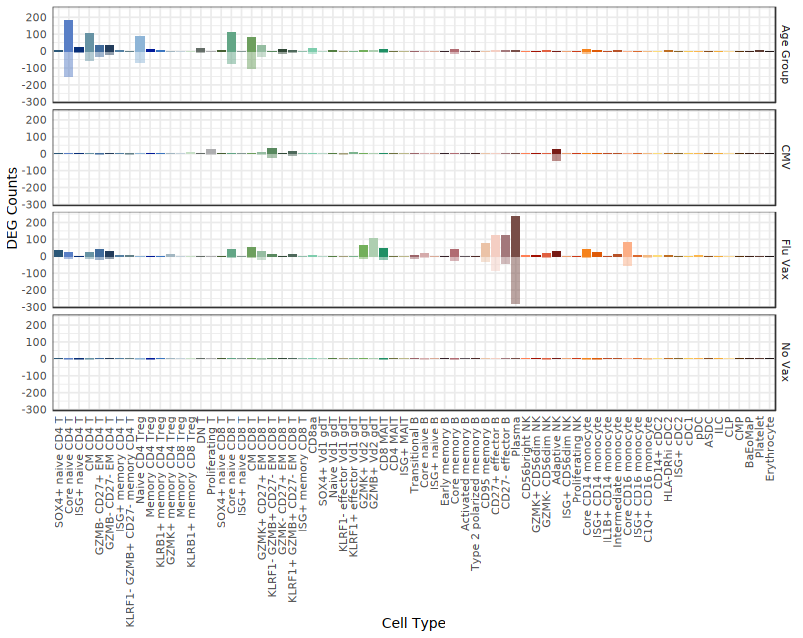

In [13]:
options(repr.plot.width = 170/25.4, repr.plot.height = 135/25.4)

p<-ggplot(deg_counts_df %>% filter(), aes(x = celltype, y = count, fill = celltype)) +
  geom_bar(stat = "identity",width=0.8,aes(alpha=Expression) ) + 
scale_fill_manual(values=color_vector)+
labs(y = "DEG Counts", x = "Cell Type") +
  scale_alpha_manual(values = c(0.5, 1)) +
  theme_bw(base_size=8)+
theme(legend.position="none")+
  theme_bw(base_size = 8) +
  facet_grid(contrast ~ .) +
  theme(
    legend.position = "none",
    strip.placement = "outside"
  ) +
  theme(
    axis.ticks = element_blank(),        # Remove axis ticks
    axis.line = element_blank(),         # Remove axis lines
    strip.background = element_blank(),  # Remove facet background
  )+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
scale_x_discrete(labels = function(x) gsub(" cell", "", x))
p
ggsave('FigureF.pdf',p, width=172/25.4,height=110/25.4)